# Econ 425T Homework 6

AUTHOR：Ruoxuan Yan

UID: 506082695

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import io
import requests
import time

In [2]:
# Scikit-Learn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

In [3]:
#conda install tensorflow

In [4]:
# Tensorflow
import tensorflow as tf
from tensorflow import keras

## 1. New York Stock Exchange (NYSE) data (1962-1986) 

In [5]:
# Read in NYSE data from url
url = "https://raw.githubusercontent.com/ucla-econ-425t/2023winter/master/slides/data/NYSE.csv"
s = requests.get(url).content.decode('utf-8')
NYSE = pd.read_csv(io.StringIO(s), index_col = 0)
NYSE

,day_of_week,DJ_return,log_volume,log_volatility,train
date,,,,,
1962-12-03,mon,-0.004461,0.032573,-13.127403,True
1962-12-04,tues,0.007813,0.346202,-11.749305,True
1962-12-05,wed,0.003845,0.525306,-11.665609,True
1962-12-06,thur,-0.003462,0.210182,-11.626772,True
1962-12-07,fri,0.000568,0.044187,-11.728130,True
...,...,...,...,...,...
1986-12-24,wed,0.006514,-0.236104,-9.807366,False
1986-12-26,fri,0.001825,-1.322425,-9.906025,False
1986-12-29,mon,-0.009515,-0.371237,-9.827660,False


<Figure size 432x288 with 0 Axes>

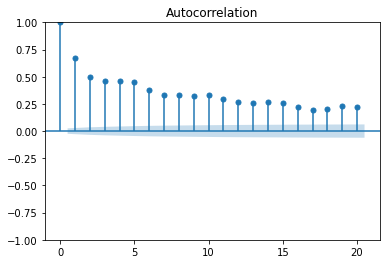

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure()
plot_acf(NYSE['log_volume'], lags = 20)
plt.show()

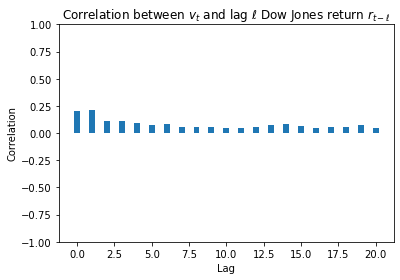

In [7]:
# (1) the correlation between v_t and lag l Dow Jones return r_t-l

# Create lag variables and the correlation between v_t and the lagged values
lags = range(0, 21)
lagged_df = pd.DataFrame({f'lag_{i}': NYSE['DJ_return'].shift(i) for i in lags})
corrs = [NYSE['log_volume'].corr(lagged_df[f'lag_{i}']) for i in lags]

# Create the plot
plt.bar(lags, corrs, width=0.4)
plt.ylim((-1, 1))
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Correlation between $v_t$ and lag $\ell$ Dow Jones return $r_{t-\ell}$')
plt.show()

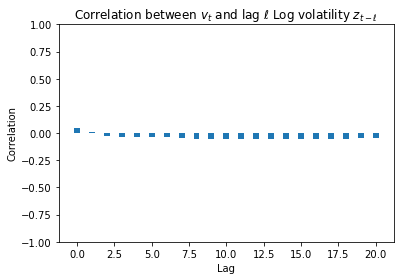

In [8]:
# (2) the correlation between v_t and lag l Log volatility z_t-l

# Create lag variables and the correlation between v_t and the lagged values
lags = range(0, 21)
lagged_df = pd.DataFrame({f'lag_{i}': NYSE['log_volatility'].shift(i) for i in lags})
corrs = [NYSE['log_volume'].corr(lagged_df[f'lag_{i}']) for i in lags]

# Create the plot
plt.bar(lags, corrs, width=0.4)
plt.ylim((-1, 1))
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Correlation between $v_t$ and lag $\ell$ Log volatility $z_{t-\ell}$')
plt.show()

In [9]:
# Create lagged variable
L = 5

for s in range(1, L+1):
    NYSE[f'DJ_return_lag{s}'] = NYSE['DJ_return'].shift(s)
    NYSE[f'log_volume_lag{s}'] = NYSE['log_volume'].shift(s)
    NYSE[f'log_volatility_lag{s}'] = NYSE['log_volatility'].shift(s)
    
NYSE = NYSE.reindex(sorted(NYSE.columns), axis = 1)
NYSE

,DJ_return,DJ_return_lag1,DJ_return_lag2,DJ_return_lag3,DJ_return_lag4,DJ_return_lag5,day_of_week,log_volatility,log_volatility_lag1,log_volatility_lag2,log_volatility_lag3,log_volatility_lag4,log_volatility_lag5,log_volume,log_volume_lag1,log_volume_lag2,log_volume_lag3,log_volume_lag4,log_volume_lag5,train
date,,,,,,,,,,,,,,,,,,,,
1962-12-03,-0.004461,NaN,NaN,NaN,NaN,NaN,mon,-13.127403,NaN,NaN,NaN,NaN,NaN,0.032573,NaN,NaN,NaN,NaN,NaN,True
1962-12-04,0.007813,-0.004461,NaN,NaN,NaN,NaN,tues,-11.749305,-13.127403,NaN,NaN,NaN,NaN,0.346202,0.032573,NaN,NaN,NaN,NaN,True
1962-12-05,0.003845,0.007813,-0.004461,NaN,NaN,NaN,wed,-11.665609,-11.749305,-13.127403,NaN,NaN,NaN,0.525306,0.346202,0.032573,NaN,NaN,NaN,True
1962-12-06,-0.003462,0.003845,0.007813,-0.004461,NaN,NaN,thur,-11.626772,-11.665609,-11.749305,-13.127403,NaN,NaN,0.210182,0.525306,0.346202,0.032573,NaN,NaN,True
1962-12-07,0.000568,-0.003462,0.003845,0.007813,-0.004461,NaN,fri,-11.728130,-11.626772,-11.665609,-11.749305,-13.127403,NaN,0.044187,0.210182,0.525306,0.346202,0.032573,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986-12-24,0.006514,-0.006150,-0.001385,0.008345,-0.002866,-0.009262,wed,-9.807366,-9.782214,-9.746214,-9.644138,-9.652473,-9.559975,-0.236104,0.450780,0.366152,0.986704,0.025079,-0.043366,False
1986-12-26,0.001825,0.006514,-0.006150,-0.001385,0.008345,-0.002866,fri,-9.906025,-9.807366,-9.782214,-9.746214,-9.644138,-9.652473,-1.322425,-0.236104,0.450780,0.366152,0.986704,0.025079,False
1986-12-29,-0.009515,0.001825,0.006514,-0.006150,-0.001385,0.008345,mon,-9.827660,-9.906025,-9.807366,-9.782214,-9.746214,-9.644138,-0.371237,-1.322425,-0.236104,0.450780,0.366152,0.986704,False


In [10]:
# Pairwise correlation
corr = NYSE.filter(regex = "log_volume*|DJ_return*|log_volatility*").corr()
corr.style.background_gradient(cmap = 'coolwarm')

,DJ_return,DJ_return_lag1,DJ_return_lag2,DJ_return_lag3,DJ_return_lag4,DJ_return_lag5,log_volatility,log_volatility_lag1,log_volatility_lag2,log_volatility_lag3,log_volatility_lag4,log_volatility_lag5,log_volume,log_volume_lag1,log_volume_lag2,log_volume_lag3,log_volume_lag4,log_volume_lag5
DJ_return,1.000000,0.143388,-0.003597,-0.005304,-0.005528,-0.014239,0.026793,0.014177,0.013557,0.010581,0.008297,0.009971,0.200892,0.047600,0.015934,0.008729,-0.004202,0.002981
DJ_return_lag1,0.143388,1.000000,0.143365,-0.003752,-0.005278,-0.005428,0.021996,0.026778,0.014163,0.013561,0.010570,0.008303,0.211669,0.200776,0.047396,0.015730,0.007997,-0.004333
DJ_return_lag2,-0.003597,0.143365,1.000000,0.143336,-0.003744,-0.005249,0.017013,0.021991,0.026773,0.014164,0.013557,0.010572,0.108032,0.211648,0.200756,0.047345,0.015549,0.007959
DJ_return_lag3,-0.005304,-0.003752,0.143336,1.000000,0.143389,-0.003602,0.011547,0.016992,0.021972,0.026780,0.014149,0.013568,0.110325,0.107846,0.211410,0.200523,0.046402,0.015366
DJ_return_lag4,-0.005528,-0.005278,-0.003744,0.143389,1.000000,0.143372,0.000350,0.011551,0.016995,0.021972,0.026783,0.014148,0.090132,0.110372,0.107921,0.211503,0.201233,0.046438
DJ_return_lag5,-0.014239,-0.005428,-0.005249,-0.003602,0.143372,1.000000,-0.006393,0.000366,0.011565,0.016994,0.021983,0.026778,0.070240,0.090282,0.110601,0.108141,0.212769,0.201379
log_volatility,0.026793,0.021996,0.017013,0.011547,0.000350,-0.006393,1.000000,0.980054,0.960890,0.943046,0.926665,0.910997,0.046306,0.036211,0.027911,0.021485,0.015350,0.003120
log_volatility_lag1,0.014177,0.026778,0.021991,0.016992,0.011551,0.000366,0.980054,1.000000,0.980054,0.960892,0.943046,0.926668,0.010394,0.046288,0.036186,0.027885,0.021425,0.015331
log_volatility_lag2,0.013557,0.014163,0.026773,0.021972,0.016995,0.011565,0.960890,0.980054,1.000000,0.980056,0.960892,0.943049,-0.029914,0.010375,0.046269,0.036164,0.027853,0.021409
log_volatility_lag3,0.010581,0.013561,0.014164,0.026780,0.021972,0.016994,0.943046,0.960892,0.980056,1.000000,0.980056,0.960892,-0.034688,-0.029913,0.010383,0.046283,0.036277,0.027859


## 2. Project goal

In [72]:
# Drop NA values of lagged variables and split the data according to train variable
NYSE_other = NYSE[NYSE['train'] == True].dropna()
print(NYSE_other.shape)
NYSE_test = NYSE[NYSE['train'] == False]
print(NYSE_test.shape)

(4276, 20)
(1770, 20)


In [73]:
# Seperate X and y

# Whether to include day_of_week
include_dow = False

if include_dow:
    X_other = NYSE_other.drop(['train', 'DJ_return', 'log_volume', 'log_volatility'], 
                              axis = 1)
    y_other = NYSE_other['log_volume']
    X_test = NYSE_test.drop(['train', 'DJ_return', 'log_volume', 'log_volatility'], 
                              axis = 1)
    y_test = NYSE_test['log_volume']
else:
    X_other = NYSE_other.drop(['train', 'DJ_return', 'log_volume', 'log_volatility', 'day_of_week'], 
                              axis = 1)
    y_other = NYSE_other['log_volume']
    X_test = NYSE_test.drop(['train', 'DJ_return', 'log_volume', 'log_volatility', 'day_of_week'], 
                              axis = 1)
    y_test = NYSE_test['log_volume']

print('Train set shape:', X_other.shape, y_other.shape)
print('Test set shape:', X_test.shape, y_test.shape)

Train set shape: (4276, 15) (4276,)
Test set shape: (1770, 15) (1770,)


## 3. Baseline method

In [508]:
# Use straw man as the baseline method and evaluate R2
R2_base_train = r2_score(y_other, X_other['log_volume_lag1'])
R2_base_test = r2_score(y_test, X_test['log_volume_lag1'])
print('Baseline method training $R^2$:', R2_base_train)
print('Baseline method testing $R^2$:', R2_base_test)

Baseline method training $R^2$: 0.4199386914132621
Baseline method testing $R^2$: 0.18026287838158628


## 4. Autoregression (AR) forecaster 

In [75]:
# Pre-processor

# List of categorical and numerical features
cat_features = X_other.select_dtypes(exclude = 'float64').columns
num_features = X_other.select_dtypes('float64').columns

# OHE transformer for categorical variables
cat_tf = Pipeline(steps = [
    ("encoder", OneHotEncoder(drop = 'first')),
    #("std", StandardScaler(with_mean = False))
])

# Transformer for continuous variables
num_tf = Pipeline(steps = [
   ("std", StandardScaler())
])

enet_col_tf = ColumnTransformer(transformers = [
    ('num', num_tf, num_features),
    ('cat', cat_tf, cat_features)
])

enet_col_tf

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('std', StandardScaler())]),
                                 Index(['DJ_return_lag1', 'DJ_return_lag2', 'DJ_return_lag3', 'DJ_return_lag4',
       'DJ_return_lag5', 'log_volatility_lag1', 'log_volatility_lag2',
       'log_volatility_lag3', 'log_volatility_lag4', 'log_volatility_lag5',
       'log_volume_lag1', 'log_volume_lag2', 'log_volume_lag3',
       'log_volume_lag4', 'log_volume_lag5'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first'))]),
                                 Index([], dtype='object'))])

In [76]:
# Elestic net model
enet_mod = ElasticNet(
    alpha = 1.0,
    l1_ratio = 0.5,
    max_iter = 10000,
    warm_start = True,
    random_state = 425,
    # selection = 'random'
)
enet_mod

ElasticNet(max_iter=10000, random_state=425, warm_start=True)

In [77]:
# Pipeline
enet_pipe = Pipeline(steps = [
  ("col_tf", enet_col_tf),
  ("model", enet_mod)
  ])
enet_pipe

Pipeline(steps=[('col_tf',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std',
                                                                   StandardScaler())]),
                                                  Index(['DJ_return_lag1', 'DJ_return_lag2', 'DJ_return_lag3', 'DJ_return_lag4',
       'DJ_return_lag5', 'log_volatility_lag1', 'log_volatility_lag2',
       'log_volatility_lag3', 'log_volatility_lag4', 'log_volatility_lag5',
       'log_volume_lag1', 'log_volume_lag2', 'log_volume_lag3',
       'log_volume_lag4', 'log_volume_lag5'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index([], dtype='object'))])),
                ('model',
   

In [78]:
# Tune hyper-parameter(s)
alpha_grid = np.logspace(start = -12, stop = 2, num = 10)
l1_ratio_grid = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
enet_tuned_parameters = {
    'model__alpha': alpha_grid,
    'model__l1_ratio': l1_ratio_grid
}
enet_tuned_parameters

{'model__alpha': array([1.00000000e-12, 3.59381366e-11, 1.29154967e-09, 4.64158883e-08,
        1.66810054e-06, 5.99484250e-05, 2.15443469e-03, 7.74263683e-02,
        2.78255940e+00, 1.00000000e+02]),
 'model__l1_ratio': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]}

In [79]:
# Set up CV
enet_search = GridSearchCV(
    enet_pipe, 
    enet_tuned_parameters, 
    cv = TimeSeriesSplit(5), 
    scoring = "r2",
    # Refit the best model on the whole data set
    refit = True 
)

In [80]:
# Fit CV
tic = time.time()
enet_search.fit(X_other, y_other)
toc = time.time()
print('Execution time:', toc - tic, 'seconds')

/Users/ireneyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.786e+00, tolerance: 2.662e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/ireneyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.254e+01, tolerance: 6.028e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solver

/Users/ireneyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.786e+00, tolerance: 2.662e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/ireneyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.254e+01, tolerance: 6.028e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solver

/Users/ireneyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.810e+00, tolerance: 2.662e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/ireneyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.259e+01, tolerance: 6.028e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solver

/Users/ireneyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.960e+01, tolerance: 6.028e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/ireneyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.764e+01, tolerance: 9.695e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solver

Execution time: 20.423112869262695 seconds


/Users/ireneyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.890e+01, tolerance: 2.278e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


<Figure size 432x288 with 0 Axes>

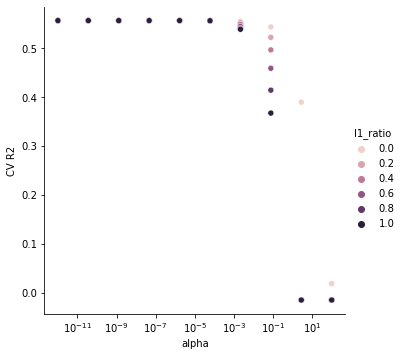

In [81]:
# Visualize CV results
cv_res = pd.DataFrame({
  "alpha": enet_search.cv_results_["param_model__alpha"],
  "r2": enet_search.cv_results_["mean_test_score"],
  "l1_ratio": enet_search.cv_results_["param_model__l1_ratio"]
  })

plt.figure()
sns.relplot(
  data = cv_res,
  x = "alpha",
  y = "r2",
  hue = "l1_ratio"
  ).set(
    xlabel = "alpha",
    ylabel = "CV R2",
    xscale = "log"
);
plt.show()

In [82]:
# Evaluate R2 of AR(5) with elastic net 

# CV R2
R2_ar_CV = enet_search.best_score_

# Training R2
R2_ar_train = r2_score(y_other, enet_search.best_estimator_.predict(X_other))

# Testing R2
R2_ar_test = r2_score(y_test, enet_search.best_estimator_.predict(X_test))

print('AR(5) with elastic net CV $R^2$:', R2_ar_CV)
print('AR(5) with elastic net training $R^2$:', R2_ar_train)
print('AR(5) with elastic net testing $R^2$:', R2_ar_test)

AR(5) with elastic net CV $R^2$: 0.5562909699696529
AR(5) with elastic net training $R^2$: 0.57071503921461
AR(5) with elastic net testing $R^2$: 0.41289129385640577


## 5. Autoregression by MLP

In [89]:
# Pre-processor

# List of categorical and numerical features
cat_features = X_other.select_dtypes(exclude = 'float64').columns
num_features = X_other.select_dtypes('float64').columns

# OHE transformer for categorical variables
cat_tf = Pipeline(steps = [
    ("encoder", OneHotEncoder(drop = 'first')),
    ("std", StandardScaler(with_mean = False))
])

# Transformer for continuous variables
num_tf = Pipeline(steps = [
   ("std", StandardScaler())
])

mlp_col_tf = ColumnTransformer(transformers = [
    ('num', num_tf, num_features),
    ('cat', cat_tf, cat_features)
])

mlp_col_tf

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('std', StandardScaler())]),
                                 Index(['DJ_return_lag1', 'DJ_return_lag2', 'DJ_return_lag3', 'DJ_return_lag4',
       'DJ_return_lag5', 'log_volatility_lag1', 'log_volatility_lag2',
       'log_volatility_lag3', 'log_volatility_lag4', 'log_volatility_lag5',
       'log_volume_lag1', 'log_volume_lag2', 'log_volume_lag3',
       'log_volume_lag4', 'log_volume_lag5'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first')),
                                                 ('std',
                                                  StandardScaler(with_mean=False))]),
                                 Index([], dtype='object'))])

In [90]:
# Model
from sklearn.neural_network import MLPRegressor

mlp_mod = MLPRegressor(
  hidden_layer_sizes = (8, 4),
  activation = 'relu',
  solver = 'adam',
  batch_size = 16,
  random_state = 425
  )

In [91]:
# Pipeline
MLP_pipe = Pipeline(steps = [
  ("col_tf", mlp_col_tf),
  ("model", mlp_mod)
  ])
MLP_pipe

Pipeline(steps=[('col_tf',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std',
                                                                   StandardScaler())]),
                                                  Index(['DJ_return_lag1', 'DJ_return_lag2', 'DJ_return_lag3', 'DJ_return_lag4',
       'DJ_return_lag5', 'log_volatility_lag1', 'log_volatility_lag2',
       'log_volatility_lag3', 'log_volatility_lag4', 'log_volatility_lag5',
       'log_volume_lag1', 'log_volume_lag2', 'log_volume_lag3',
       'log_volume_lag4', 'log_volume_lag5'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first')),
                                                                  ('std',
                                      

In [96]:
# Tune hyper-parameter(s)
hls_grid = [ (4, 2), (6, 3), (8, 4), (12, 6), (20,20,), (10,20,10,)] # hidden layer size
bs_grid = [4, 8, 12, 16, 20, 24, 32] # batch sizes
MLP_tuned_parameters = {
  "model__hidden_layer_sizes": hls_grid,
  "model__batch_size": bs_grid
  }
MLP_tuned_parameters

{'model__hidden_layer_sizes': [(4, 2),
  (6, 3),
  (8, 4),
  (12, 6),
  (20, 20),
  (10, 20, 10)],
 'model__batch_size': [4, 8, 12, 16, 20, 24, 32]}

In [97]:
# Set up CV
MLP_search = GridSearchCV(
  MLP_pipe,
  MLP_tuned_parameters,
  cv = TimeSeriesSplit(5),  
  scoring = "r2",
  # Refit the best model on the whole data set
  refit = True
  )

In [98]:
# Fit CV
tic = time.time()
MLP_search.fit(X_other, y_other)
toc = time.time()
print('Execution time:', toc - tic, 'seconds')

Execution time: 280.2636299133301 seconds


In [101]:
# Best estimator
MLP_search.best_estimator_

Pipeline(steps=[('col_tf',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std',
                                                                   StandardScaler())]),
                                                  Index(['DJ_return_lag1', 'DJ_return_lag2', 'DJ_return_lag3', 'DJ_return_lag4',
       'DJ_return_lag5', 'log_volatility_lag1', 'log_volatility_lag2',
       'log_volatility_lag3', 'log_volatility_lag4', 'log_volatility_lag5',
       'log_volume_lag1', 'log_volume_lag2', 'log_volume_lag3',
       'log_volume_lag4', 'log_volume_lag5'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first')),
                                                                  ('std',
                                      

<Figure size 432x288 with 0 Axes>

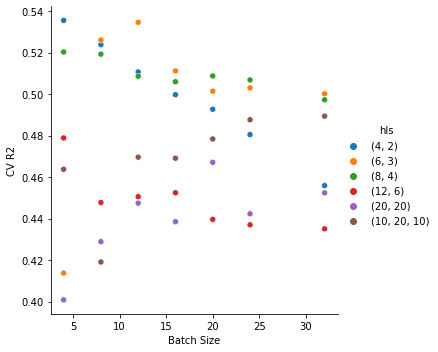

In [99]:
# Visualize CV results
cv_res = pd.DataFrame({
  "bs": np.array(MLP_search.cv_results_["param_model__batch_size"]),
  "r2": MLP_search.cv_results_["mean_test_score"],
  "hls": MLP_search.cv_results_["param_model__hidden_layer_sizes"]
  })

plt.figure()
sns.relplot(
  # kind = "line",
  data = cv_res,
  x = "bs",
  y = "r2",
  hue = "hls"
  ).set(
    # xscale = "log",
    xlabel = "Batch Size",
    ylabel = "CV R2"
    );
plt.show()

In [488]:
# Evaluate R2 of MLP

# CV R2
R2_mlp_CV = MLP_search.best_score_

# Training R2
R2_mlp_train = r2_score(y_other, MLP_search.best_estimator_.predict(X_other))

# Testing R2
R2_mlp_test = r2_score(y_test, MLP_search.best_estimator_.predict(X_test))

print('MLP CV $R^2$:', R2_mlp_CV)
print('MLP training $R^2$:', R2_mlp_train)
print('MLP testing $R^2$:', R2_mlp_test)

MLP CV $R^2$: 0.5355117824558622
MLP training $R^2$: 0.5921450753059991
MLP testing $R^2$: 0.4065541002666947


## 6. LSTM forecaster

In [516]:
# Pre-processor

# split the data
train_val_split_fraction = 0.8
train_split = int(train_val_split_fraction*int(X_other.shape[0]))

if include_dow:
    predictors = ['log_volatility', 'DJ_return', 'log_volume', 'day_of_week']
else:
    predictors = ['log_volatility', 'DJ_return', 'log_volume']
batch_size = 16
learning_rate = 0.001
epochs = 20
sequence_length = 5

# Train data
train_data = NYSE[predictors].iloc[0 : train_split - 1]
X_train = train_data[[i for i in predictors]].values
y_train = NYSE['log_volume'].iloc[L:train_split]
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length = sequence_length,
    sampling_rate = 1,
    batch_size = batch_size,
    shuffle = False
)

In [517]:
# Show the data size of a training batch
for batch in dataset_train.take(1):
    inputs, targets = batch
    
print('Input shape', inputs.numpy().shape)
print('Target shape', targets.numpy().shape)

Input shape (16, 5, 3)
Target shape (16,)


In [518]:
# Sanity check
inputs.numpy()

array([[[-1.31274026e+01, -4.46100000e-03,  3.25730000e-02],
        [-1.17493047e+01,  7.81300000e-03,  3.46202000e-01],
        [-1.16656090e+01,  3.84500000e-03,  5.25306000e-01],
        [-1.16267724e+01, -3.46200000e-03,  2.10182000e-01],
        [-1.17281302e+01,  5.68000000e-04,  4.41870000e-02]],

       [[-1.17493047e+01,  7.81300000e-03,  3.46202000e-01],
        [-1.16656090e+01,  3.84500000e-03,  5.25306000e-01],
        [-1.16267724e+01, -3.46200000e-03,  2.10182000e-01],
        [-1.17281302e+01,  5.68000000e-04,  4.41870000e-02],
        [-1.08725263e+01, -1.08240000e-02,  1.33246000e-01]],

       [[-1.16656090e+01,  3.84500000e-03,  5.25306000e-01],
        [-1.16267724e+01, -3.46200000e-03,  2.10182000e-01],
        [-1.17281302e+01,  5.68000000e-04,  4.41870000e-02],
        [-1.08725263e+01, -1.08240000e-02,  1.33246000e-01],
        [-1.09777968e+01,  1.24000000e-04, -1.15280000e-02]],

       [[-1.16267724e+01, -3.46200000e-03,  2.10182000e-01],
        [-1.172813

In [519]:
targets.numpy()

array([ 0.133246, -0.011528,  0.001607, -0.106437, -0.138269, -0.049635,
       -0.043387,  0.053629,  0.104624, -0.088976, -0.176311, -0.118011,
       -0.03438 ,  0.083565,  0.346693, -0.413953])

In [520]:
NYSE[predictors].head(10)

,log_volatility,DJ_return,log_volume
date,,,
1962-12-03,-13.127403,-0.004461,0.032573
1962-12-04,-11.749305,0.007813,0.346202
1962-12-05,-11.665609,0.003845,0.525306
1962-12-06,-11.626772,-0.003462,0.210182
1962-12-07,-11.728130,0.000568,0.044187
1962-12-10,-10.872526,-0.010824,0.133246
1962-12-11,-10.977797,0.000124,-0.011528
1962-12-12,-11.012360,0.003358,0.001607
1962-12-13,-11.047108,-0.003296,-0.106437


In [521]:
for batch in dataset_train.take(-1):
    inputs, targets = batch
    
print('Input shape', inputs.numpy().shape)
print('Target shape', targets.numpy().shape)

Input shape (7, 5, 3)
Target shape (7,)


In [522]:
# Sanity check
inputs.numpy()

array([[[-1.02170860e+01, -2.39900000e-03, -1.28851000e-01],
        [-1.03026108e+01, -2.56700000e-03, -8.75380000e-02],
        [-1.04035015e+01,  1.16300000e-03, -1.07453000e-01],
        [-1.04988632e+01,  1.65600000e-03, -2.66158000e-01],
        [-1.06041050e+01, -1.72000000e-04, -2.43651000e-01]],

       [[-1.03026108e+01, -2.56700000e-03, -8.75380000e-02],
        [-1.04035015e+01,  1.16300000e-03, -1.07453000e-01],
        [-1.04988632e+01,  1.65600000e-03, -2.66158000e-01],
        [-1.06041050e+01, -1.72000000e-04, -2.43651000e-01],
        [-1.07078260e+01,  6.05000000e-04, -3.96705000e-01]],

       [[-1.04035015e+01,  1.16300000e-03, -1.07453000e-01],
        [-1.04988632e+01,  1.65600000e-03, -2.66158000e-01],
        [-1.06041050e+01, -1.72000000e-04, -2.43651000e-01],
        [-1.07078260e+01,  6.05000000e-04, -3.96705000e-01],
        [-1.05684789e+01, -7.47100000e-03, -2.50686000e-01]],

       [[-1.04988632e+01,  1.65600000e-03, -2.66158000e-01],
        [-1.060410

In [523]:
targets.numpy()

array([-0.396705, -0.250686, -0.220054, -0.396163, -0.280221, -0.349905,
       -0.05663 ])

In [524]:
y_train = NYSE['log_volume'].iloc[train_split - 1]
y_train 

-0.05663

In [525]:
# Validation data
val_data = NYSE.iloc[(train_split - L) : (X_other.shape[0] + L -1)]
X_val = val_data[[i for i in predictors]].values
y_val = NYSE['log_volume'].iloc[train_split:(X_other.shape[0] + L)]
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length = sequence_length,
    sampling_rate = 1,
    batch_size = batch_size,
)

In [526]:
X_other.shape[0]

4276

In [527]:
len(NYSE)

6051

In [528]:
(X_other.shape[0] + 1)

4277

In [529]:
y_val.tail(10)

date
1979-12-17    0.199621
1979-12-18    0.183537
1979-12-19    0.144112
1979-12-20    0.108579
1979-12-21   -0.001507
1979-12-24   -0.631830
1979-12-26   -0.365829
1979-12-27   -0.137014
1979-12-28   -0.041932
1979-12-31   -0.125945
Name: log_volume, dtype: float64

In [530]:
val_data.tail(10)

,DJ_return,DJ_return_lag1,DJ_return_lag2,DJ_return_lag3,DJ_return_lag4,DJ_return_lag5,day_of_week,log_volatility,log_volatility_lag1,log_volatility_lag2,log_volatility_lag3,log_volatility_lag4,log_volatility_lag5,log_volume,log_volume_lag1,log_volume_lag2,log_volume_lag3,log_volume_lag4,log_volume_lag5,train
date,,,,,,,,,,,,,,,,,,,,
1979-12-14,0.007934,0.000502,0.002360,-0.000204,0.000816,-0.002254,fri,-10.068394,-10.123755,-10.019025,-9.926248,-9.820973,-9.716839,0.155221,0.026541,-0.029469,0.015775,-0.095451,0.178229,True
1979-12-17,0.002216,0.007934,0.000502,0.002360,-0.000204,0.000816,mon,-10.160962,-10.068394,-10.123755,-10.019025,-9.926248,-9.820973,0.199621,0.155221,0.026541,-0.029469,0.015775,-0.095451,True
1979-12-18,-0.007093,0.002216,0.007934,0.000502,0.002360,-0.000204,tues,-10.131226,-10.160962,-10.068394,-10.123755,-10.019025,-9.926248,0.183537,0.199621,0.155221,0.026541,-0.029469,0.015775,True
1979-12-19,0.000310,-0.007093,0.002216,0.007934,0.000502,0.002360,wed,-10.236318,-10.131226,-10.160962,-10.068394,-10.123755,-10.019025,0.144112,0.183537,0.199621,0.155221,0.026541,-0.029469,True
1979-12-20,0.005267,0.000310,-0.007093,0.002216,0.007934,0.000502,thur,-10.259191,-10.236318,-10.131226,-10.160962,-10.068394,-10.123755,0.108579,0.144112,0.183537,0.199621,0.155221,0.026541,True
1979-12-21,-0.005267,0.005267,0.000310,-0.007093,0.002216,0.007934,fri,-10.280234,-10.259191,-10.236318,-10.131226,-10.160962,-10.068394,-0.001507,0.108579,0.144112,0.183537,0.199621,0.155221,True
1979-12-24,0.000298,-0.005267,0.005267,0.000310,-0.007093,0.002216,mon,-10.385307,-10.280234,-10.259191,-10.236318,-10.131226,-10.160962,-0.631830,-0.001507,0.108579,0.144112,0.183537,0.199621,True
1979-12-26,-0.001216,0.000298,-0.005267,0.005267,0.000310,-0.007093,wed,-10.485360,-10.385307,-10.280234,-10.259191,-10.236318,-10.131226,-0.365829,-0.631830,-0.001507,0.108579,0.144112,0.183537,True
1979-12-27,0.002336,-0.001216,0.000298,-0.005267,0.005267,0.000310,thur,-10.569258,-10.485360,-10.385307,-10.280234,-10.259191,-10.236318,-0.137014,-0.365829,-0.631830,-0.001507,0.108579,0.144112,True


In [531]:
# Show the data size of a validation batch
for batch in dataset_val.take(1):
    inputs, targets = batch
    
print('Input shape', inputs.numpy().shape)
print('Target shape', targets.numpy().shape)

Input shape (16, 5, 3)
Target shape (16,)


In [532]:
for batch in dataset_val.take(-1):
    inputs, targets = batch
print('Input shape', inputs.numpy().shape)
print('Target shape', targets.numpy().shape)

Input shape (13, 5, 3)
Target shape (13,)


In [533]:
inputs.numpy()

array([[[-9.61614584e+00,  4.23400000e-03,  1.05294000e-01],
        [-9.61994378e+00,  8.00700000e-03,  5.79800000e-02],
        [-9.71683871e+00, -2.25400000e-03,  1.78229000e-01],
        [-9.82097289e+00,  8.16000000e-04, -9.54510000e-02],
        [-9.92624822e+00, -2.04000000e-04,  1.57750000e-02]],

       [[-9.61994378e+00,  8.00700000e-03,  5.79800000e-02],
        [-9.71683871e+00, -2.25400000e-03,  1.78229000e-01],
        [-9.82097289e+00,  8.16000000e-04, -9.54510000e-02],
        [-9.92624822e+00, -2.04000000e-04,  1.57750000e-02],
        [-1.00190246e+01,  2.36000000e-03, -2.94690000e-02]],

       [[-9.71683871e+00, -2.25400000e-03,  1.78229000e-01],
        [-9.82097289e+00,  8.16000000e-04, -9.54510000e-02],
        [-9.92624822e+00, -2.04000000e-04,  1.57750000e-02],
        [-1.00190246e+01,  2.36000000e-03, -2.94690000e-02],
        [-1.01237555e+01,  5.02000000e-04,  2.65410000e-02]],

       [[-9.82097289e+00,  8.16000000e-04, -9.54510000e-02],
        [-9.926248

In [534]:
targets.numpy()

array([-0.029469,  0.026541,  0.155221,  0.199621,  0.183537,  0.144112,
        0.108579, -0.001507, -0.63183 , -0.365829, -0.137014, -0.041932,
       -0.125945])

In [535]:
NYSE['log_volume'].iloc[train_split:(X_other.shape[0] + L)]

date
1976-08-04    0.056781
1976-08-05   -0.225546
1976-08-06   -0.329082
1976-08-09   -0.495290
1976-08-10   -0.137599
                ...   
1979-12-24   -0.631830
1979-12-26   -0.365829
1979-12-27   -0.137014
1979-12-28   -0.041932
1979-12-31   -0.125945
Name: log_volume, Length: 861, dtype: float64

In [569]:
# Model
inputs = keras.layers.Input(
    shape = (inputs.shape[1], inputs.shape[2])
    )

lstm_out = keras.layers.LSTM(12)(inputs)
#dense_out = keras.layers.Dense(4)(lstm_out1)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(
    inputs = inputs,
    outputs = outputs
)
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
    loss = "mse",
    metrics = [tf.keras.metrics.CosineSimilarity(axis = 1)]
)

In [570]:
(inputs.shape[1], inputs.shape[2])

(5, 3)

In [571]:
model.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 5, 3)]            0         
                                                                 
 lstm_41 (LSTM)              (None, 12)                768       
                                                                 
 dense_42 (Dense)            (None, 1)                 13        
                                                                 
Total params: 781
Trainable params: 781
Non-trainable params: 0
_________________________________________________________________


In [572]:
np.random.seed(42)
tf.random.set_seed(42)
history = model.fit(
    dataset_train,
    epochs = epochs,
    validation_data = dataset_val,
    verbose = 2
)

Epoch 1/20
214/214 - 2s - loss: 0.0429 - cosine_similarity: 0.3184 - val_loss: 0.0318 - val_cosine_similarity: 0.4611 - 2s/epoch - 7ms/step
Epoch 2/20
214/214 - 0s - loss: 0.0290 - cosine_similarity: 0.5485 - val_loss: 0.0277 - val_cosine_similarity: 0.4843 - 460ms/epoch - 2ms/step
Epoch 3/20
214/214 - 0s - loss: 0.0265 - cosine_similarity: 0.5660 - val_loss: 0.0272 - val_cosine_similarity: 0.4704 - 476ms/epoch - 2ms/step
Epoch 4/20
214/214 - 0s - loss: 0.0260 - cosine_similarity: 0.5713 - val_loss: 0.0270 - val_cosine_similarity: 0.4681 - 439ms/epoch - 2ms/step
Epoch 5/20
214/214 - 0s - loss: 0.0257 - cosine_similarity: 0.5713 - val_loss: 0.0268 - val_cosine_similarity: 0.4797 - 429ms/epoch - 2ms/step
Epoch 6/20
214/214 - 0s - loss: 0.0255 - cosine_similarity: 0.5742 - val_loss: 0.0265 - val_cosine_similarity: 0.4797 - 411ms/epoch - 2ms/step
Epoch 7/20
214/214 - 0s - loss: 0.0253 - cosine_similarity: 0.5818 - val_loss: 0.0263 - val_cosine_similarity: 0.4820 - 412ms/epoch - 2ms/step
Ep

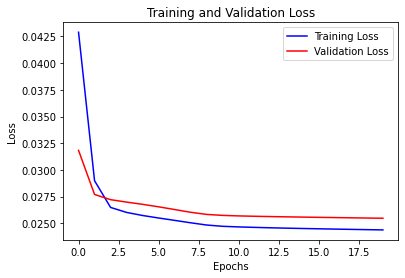

In [573]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label = "Training Loss")
    plt.plot(epochs, val_loss, "r", label = "Validation Loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
visualize_loss(history, "Training and Validation Loss")

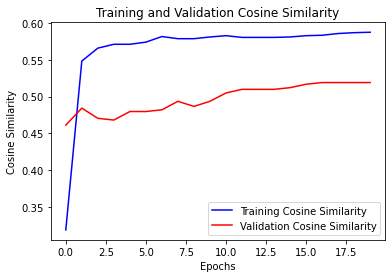

In [574]:
def visualize_cossim(history, title):
    cossim = history.history["cosine_similarity"]
    val_cossim = history.history["val_cosine_similarity"]
    epochs = range(len(cossim))
    plt.figure()
    plt.plot(epochs, cossim, "b", label = "Training Cosine Similarity")
    plt.plot(epochs, val_cossim, "r", label = "Validation Cosine Similarity")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Cosine Similarity")
    plt.legend()
    plt.show()
    
visualize_cossim(history, "Training and Validation Cosine Similarity")

In [575]:
# Test data
test_data = NYSE[predictors].iloc[NYSE_other.shape[0]:len(NYSE[predictors])-1]
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    test_data[[i for i in predictors]].values,
    y_test,
    sequence_length = sequence_length,
    sampling_rate = 1,
    batch_size = batch_size,
)

In [576]:
y_val

date
1976-08-04    0.056781
1976-08-05   -0.225546
1976-08-06   -0.329082
1976-08-09   -0.495290
1976-08-10   -0.137599
                ...   
1979-12-24   -0.631830
1979-12-26   -0.365829
1979-12-27   -0.137014
1979-12-28   -0.041932
1979-12-31   -0.125945
Name: log_volume, Length: 861, dtype: float64

In [577]:
val_data

,DJ_return,DJ_return_lag1,DJ_return_lag2,DJ_return_lag3,DJ_return_lag4,DJ_return_lag5,day_of_week,log_volatility,log_volatility_lag1,log_volatility_lag2,log_volatility_lag3,log_volatility_lag4,log_volatility_lag5,log_volume,log_volume_lag1,log_volume_lag2,log_volume_lag3,log_volume_lag4,log_volume_lag5,train
date,,,,,,,,,,,,,,,,,,,,
1976-07-28,-0.002849,-0.007471,0.000605,-0.000172,0.001656,0.001163,wed,-10.639362,-10.568479,-10.707826,-10.604105,-10.498863,-10.403502,-0.220054,-0.250686,-0.396705,-0.243651,-0.266158,-0.107453,True
1976-07-29,-0.002081,-0.002849,-0.007471,0.000605,-0.000172,0.001656,thur,-10.724835,-10.639362,-10.568479,-10.707826,-10.604105,-10.498863,-0.396163,-0.220054,-0.250686,-0.396705,-0.243651,-0.266158,True
1976-07-30,0.005448,-0.002081,-0.002849,-0.007471,0.000605,-0.000172,fri,-10.690458,-10.724835,-10.639362,-10.568479,-10.707826,-10.604105,-0.280221,-0.396163,-0.220054,-0.250686,-0.396705,-0.243651,True
1976-08-02,-0.002420,0.005448,-0.002081,-0.002849,-0.007471,0.000605,mon,-10.767629,-10.690458,-10.724835,-10.639362,-10.568479,-10.707826,-0.349905,-0.280221,-0.396163,-0.220054,-0.250686,-0.396705,True
1976-08-03,0.008182,-0.002420,0.005448,-0.002081,-0.002849,-0.007471,tues,-10.570640,-10.767629,-10.690458,-10.724835,-10.639362,-10.568479,-0.056630,-0.349905,-0.280221,-0.396163,-0.220054,-0.250686,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979-12-21,-0.005267,0.005267,0.000310,-0.007093,0.002216,0.007934,fri,-10.280234,-10.259191,-10.236318,-10.131226,-10.160962,-10.068394,-0.001507,0.108579,0.144112,0.183537,0.199621,0.155221,True
1979-12-24,0.000298,-0.005267,0.005267,0.000310,-0.007093,0.002216,mon,-10.385307,-10.280234,-10.259191,-10.236318,-10.131226,-10.160962,-0.631830,-0.001507,0.108579,0.144112,0.183537,0.199621,True
1979-12-26,-0.001216,0.000298,-0.005267,0.005267,0.000310,-0.007093,wed,-10.485360,-10.385307,-10.280234,-10.259191,-10.236318,-10.131226,-0.365829,-0.631830,-0.001507,0.108579,0.144112,0.183537,True


In [578]:
test_data.head(10)

,log_volatility,DJ_return,log_volume
date,,,
1979-12-24,-10.385307,0.000298,-0.631830
1979-12-26,-10.485360,-0.001216,-0.365829
1979-12-27,-10.569258,0.002336,-0.137014
1979-12-28,-10.665966,-0.001418,-0.041932
1979-12-31,-10.771131,-0.000203,-0.125945
1980-01-02,-9.945787,-0.017039,0.117599
1980-01-03,-9.990808,-0.005180,0.331630
1980-01-04,-9.865445,0.010345,0.078033
1980-01-07,-9.940298,0.003805,0.205938


In [579]:
y_test

date
1980-01-02    0.117599
1980-01-03    0.331630
1980-01-04    0.078033
1980-01-07    0.205938
1980-01-08    0.386403
                ...   
1986-12-24   -0.236104
1986-12-26   -1.322425
1986-12-29   -0.371237
1986-12-30   -0.385638
1986-12-31   -0.264986
Name: log_volume, Length: 1770, dtype: float64

In [580]:
# Show the data size of a test batch
for batch in dataset_test.take(1):
    inputs, targets = batch
    
print('Input shape', inputs.numpy().shape)
print('Target shape', targets.numpy().shape)

Input shape (16, 5, 3)
Target shape (16,)


In [581]:
inputs.numpy()

array([[[-1.03853073e+01,  2.98000000e-04, -6.31830000e-01],
        [-1.04853599e+01, -1.21600000e-03, -3.65829000e-01],
        [-1.05692577e+01,  2.33600000e-03, -1.37014000e-01],
        [-1.06659664e+01, -1.41800000e-03, -4.19320000e-02],
        [-1.07711315e+01, -2.03000000e-04, -1.25945000e-01]],

       [[-1.04853599e+01, -1.21600000e-03, -3.65829000e-01],
        [-1.05692577e+01,  2.33600000e-03, -1.37014000e-01],
        [-1.06659664e+01, -1.41800000e-03, -4.19320000e-02],
        [-1.07711315e+01, -2.03000000e-04, -1.25945000e-01],
        [-9.94578731e+00, -1.70390000e-02,  1.17599000e-01]],

       [[-1.05692577e+01,  2.33600000e-03, -1.37014000e-01],
        [-1.06659664e+01, -1.41800000e-03, -4.19320000e-02],
        [-1.07711315e+01, -2.03000000e-04, -1.25945000e-01],
        [-9.94578731e+00, -1.70390000e-02,  1.17599000e-01],
        [-9.99080843e+00, -5.18000000e-03,  3.31630000e-01]],

       [[-1.06659664e+01, -1.41800000e-03, -4.19320000e-02],
        [-1.077113

In [582]:
targets.numpy()

array([0.117599, 0.33163 , 0.078033, 0.205938, 0.386403, 0.582476,
       0.422659, 0.360512, 0.357735, 0.342675, 0.592056, 0.363617,
       0.221044, 0.235036, 0.282358, 0.27913 ])

In [583]:
score, cossim = model.evaluate(
    dataset_test,
    batch_size = batch_size,
    verbose = 2
)

print("Test score", score)
print("Test metic", cossim)

111/111 - 0s - loss: 0.0361 - cosine_similarity: 0.4441 - 127ms/epoch - 1ms/step
Test score 0.03612610697746277
Test metic 0.4440678060054779


In [584]:
r2_test_lstm = r2_score(
    y_test,
    np.c_[model.predict(
    dataset_test,
    batch_size = batch_size,
    verbose = 2
    )].flatten()
)
r2_test_lstm

111/111 - 0s - 340ms/epoch - 3ms/step


0.3720545075839581

## 7. Random forest forecaster 

In [477]:
# Pre-processor

# List of categorical and numerical features
cat_features = X_other.select_dtypes(exclude = 'float64').columns
num_features = X_other.select_dtypes('float64').columns

# OHE transformer for categorical variables
cat_tf = Pipeline(steps = [
    ("encoder", OneHotEncoder(drop = 'first')),
    ("std", StandardScaler(with_mean = False))
])

# Transformer for continuous variables
num_tf = Pipeline(steps = [
   ("std", StandardScaler())
])

rf_col_tf = ColumnTransformer(transformers = [
    ('num', num_tf, num_features),
    ('cat', cat_tf, cat_features)
])

rf_col_tf

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('std', StandardScaler())]),
                                 Index(['DJ_return_lag1', 'DJ_return_lag2', 'DJ_return_lag3', 'DJ_return_lag4',
       'DJ_return_lag5', 'log_volatility_lag1', 'log_volatility_lag2',
       'log_volatility_lag3', 'log_volatility_lag4', 'log_volatility_lag5',
       'log_volume_lag1', 'log_volume_lag2', 'log_volume_lag3',
       'log_volume_lag4', 'log_volume_lag5'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first')),
                                                 ('std',
                                                  StandardScaler(with_mean=False))]),
                                 Index([], dtype='object'))])

In [478]:
# Model

rf_mod =  RandomForestRegressor(
  # Number of trees
  n_estimators = 100, 
  criterion = 'squared_error',
  # Number of features to use in each split
  max_features = 'sqrt',
  oob_score = True,
  random_state = 425
  )

In [479]:
# Pipeline
rf_pipe = Pipeline(steps = [
  ("col_tf", rf_col_tf),
  ("model", rf_mod)
  ])
rf_pipe

Pipeline(steps=[('col_tf',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std',
                                                                   StandardScaler())]),
                                                  Index(['DJ_return_lag1', 'DJ_return_lag2', 'DJ_return_lag3', 'DJ_return_lag4',
       'DJ_return_lag5', 'log_volatility_lag1', 'log_volatility_lag2',
       'log_volatility_lag3', 'log_volatility_lag4', 'log_volatility_lag5',
       'log_volume_lag1', 'log_volume_lag2', 'log_volume_lag3',
       'log_volume_lag4', 'log_volume_lag5'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first')),
                                                                  ('std',
                                      

In [480]:
# Tune hyper-parameter(s)
B_grid = [50, 100, 150, 200, 250, 300]
m_grid = ['sqrt', 'log2', 1.0] # max_features = 1.0 uses all features
tuned_parameters = {
  "model__n_estimators": B_grid,
  "model__max_features": m_grid
  }
tuned_parameters

{'model__n_estimators': [50, 100, 150, 200, 250, 300],
 'model__max_features': ['sqrt', 'log2', 1.0]}

In [481]:
# Set up CV
rf_search = GridSearchCV(
  rf_pipe,
  tuned_parameters,
  cv = TimeSeriesSplit(5), 
  scoring = "r2",
  # Refit the best model on the whole data set
  refit = True
  )

In [482]:
# Fit CV
tic = time.time()
rf_search.fit(X_other, y_other)
toc = time.time()
print('Execution time:', toc - tic, 'seconds')

Execution time: 152.28797316551208 seconds


<Figure size 432x288 with 0 Axes>

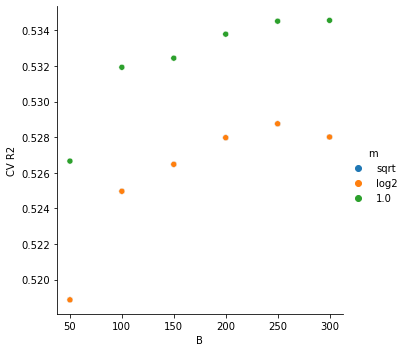

In [483]:
# Visualize CV results
cv_res = pd.DataFrame({
  "B": np.array(rf_search.cv_results_["param_model__n_estimators"]),
  "r2": rf_search.cv_results_["mean_test_score"],
  "m": rf_search.cv_results_["param_model__max_features"]
  })

plt.figure()
sns.relplot(
  # kind = "line",
  data = cv_res,
  x = "B",
  y = "r2",
  hue = "m",
  ).set(
    xlabel = "B",
    ylabel = "CV R2"
);
plt.show()

In [487]:
# Evaluate R2 of Random forest forecaster

# CV R2
R2_rf_CV = rf_search.best_score_

# Training R2
R2_rf_train = r2_score(y_other, rf_search.best_estimator_.predict(X_other))

# Testing R2
R2_rf_test = r2_score(y_test, rf_search.best_estimator_.predict(X_test))

print('Random forest forecaster CV $R^2$:', R2_rf_CV)
print('Random forest forecaster training $R^2$:', R2_rf_train)
print('Random forest forecaster testing $R^2$:', R2_rf_test)

Random forest forecaster CV $R^2$: 0.5345646026399085
Random forest forecaster training $R^2$: 0.940728889480386
Random forest forecaster testing $R^2$: 0.40042340650148023


## 8. Boosting forecaster

In [491]:
# Pre-processor

# List of categorical and numerical features
cat_features = X_other.select_dtypes(exclude = 'float64').columns
num_features = X_other.select_dtypes('float64').columns

# OHE transformer for categorical variables
cat_tf = Pipeline(steps = [
    ("encoder", OneHotEncoder(drop = 'first')),
    ("std", StandardScaler(with_mean = False))
])

# Transformer for continuous variables
num_tf = Pipeline(steps = [
   ("std", StandardScaler())
])

xgb_col_tf = ColumnTransformer(transformers = [
    ('num', num_tf, num_features),
    ('cat', cat_tf, cat_features)
])

xgb_col_tf

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('std', StandardScaler())]),
                                 Index(['DJ_return_lag1', 'DJ_return_lag2', 'DJ_return_lag3', 'DJ_return_lag4',
       'DJ_return_lag5', 'log_volatility_lag1', 'log_volatility_lag2',
       'log_volatility_lag3', 'log_volatility_lag4', 'log_volatility_lag5',
       'log_volume_lag1', 'log_volume_lag2', 'log_volume_lag3',
       'log_volume_lag4', 'log_volume_lag5'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first')),
                                                 ('std',
                                                  StandardScaler(with_mean=False))]),
                                 Index([], dtype='object'))])

In [493]:
# pip install xgboost

     |████████████████████████████████| 1.8 MB 2.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [494]:
# Model
import xgboost as xgb
xgb_mod =  xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state = 425
                )

In [495]:
# Pipeline
xgb_pipe = Pipeline(steps = [
  ("col_tf", xgb_col_tf),
  ("model", xgb_mod)
  ])
xgb_pipe

Pipeline(steps=[('col_tf',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std',
                                                                   StandardScaler())]),
                                                  Index(['DJ_return_lag1', 'DJ_return_lag2', 'DJ_return_lag3', 'DJ_return_lag4',
       'DJ_return_lag5', 'log_volatility_lag1', 'log_volatility_lag2',
       'log_volatility_lag3', 'log_volatility_lag4', 'log_volatility_lag5',
       'log_volume_lag1', 'log_volume_lag2', 'log...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=

In [501]:
# Tune hyper-parameter(s)
max_depth = [1, 3, 5, 7]
n_estimators = [50, 100, 150, 200]
learning_rate = [0.05, 0.1, 0.3, 0.5, 0.7]
tuned_parameters = {
  "model__max_depth": max_depth,
  "model__n_estimators": n_estimators, 
  "model__learning_rate": learning_rate
  }
tuned_parameters

{'model__max_depth': [1, 3, 5, 7],
 'model__n_estimators': [50, 100, 150, 200],
 'model__learning_rate': [0.05, 0.1, 0.3, 0.5, 0.7]}

In [502]:
# Set up CV
xgb_search = GridSearchCV(
  xgb_pipe,
  tuned_parameters,
  cv = TimeSeriesSplit(5), 
  scoring = "r2",
  # Refit the best model on the whole data set
  refit = True
  )

In [503]:
# Fit CV
tic = time.time()
xgb_search.fit(X_other, y_other)
toc = time.time()
print('Execution time:', toc - tic, 'seconds')

Execution time: 74.40721106529236 seconds


<Figure size 432x288 with 0 Axes>

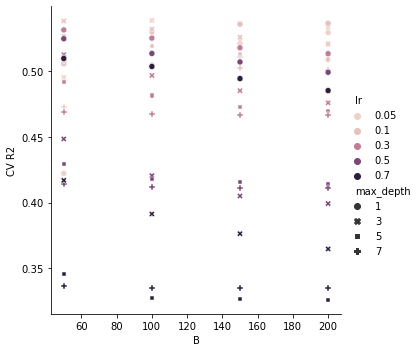

In [504]:
# Visualize CV results
cv_res = pd.DataFrame({
  "B": np.array(xgb_search.cv_results_["param_model__n_estimators"]),
  "r2": xgb_search.cv_results_["mean_test_score"],
  "lr": xgb_search.cv_results_["param_model__learning_rate"],
  "max_depth": xgb_search.cv_results_["param_model__max_depth"]
  })

plt.figure()
sns.relplot(
  # kind = "line",
  data = cv_res,
  x = "B",
  y = "r2",
  hue = "lr",
  style = "max_depth"
  ).set(
    xlabel = "B",
    ylabel = "CV R2"
);
plt.show()

In [509]:
# Evaluate R2 of Random forest forecaster

# CV R2
R2_xgb_CV = xgb_search.best_score_

# Training R2
R2_xgb_train = r2_score(y_other, xgb_search.best_estimator_.predict(X_other))

# Testing R2
R2_xgb_test = r2_score(y_test, xgb_search.best_estimator_.predict(X_test))

print('Boosting CV $R^2$:', R2_xgb_CV)
print('Boosting training $R^2$:', R2_xgb_train)
print('Boosting testing $R^2$:', R2_xgb_test)

Boosting CV $R^2$: 0.5385791917161622
Boosting training $R^2$: 0.6286041342112926
Boosting testing $R^2$: 0.41332455056697237


## 9. Summary

Summarize the performance of different machine learning forecasters in the following format.


| Method | CV $R^2$ | Training $R^2$ | Test $R^2$ |
|:------:|:------:|:------:|:------:|
| Baseline | - | 0.4199 | 0.1803 |
| AR(5) | 0.5563 | 0.5707 | 0.4129 |
| AR(5) MLP | 0.5355 | 0.5921 | 0.4066 |
| LSTM | - | - | 0.3721 |
| Random Forest | 0.5346 | 0.9407 | 0.4004 |
| Boosting | 0.5386 | 0.6286 | 0.4133 |
